In [40]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio base donde están las imágenes
base_dir = Path("Dogs2")

# Configuración de parámetros
IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 8

# Data Augmentation para prevenir overfitting
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalización
    rotation_range=30,          # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.2,      # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,     # Desplazamiento vertical aleatorio
    zoom_range=0.2,             # Zoom aleatorio
    horizontal_flip=True,       # Flip horizontal
    fill_mode='nearest',        # Rellenar espacios tras transformaciones
    validation_split=0.2        # Dividir en 80% entrenamiento, 20% validación
)

# Generadores para datos de entrenamiento y validación
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Subset de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Subset de validación
)

# Visualizar las clases y número de imágenes por clase
print("Clases detectadas:", train_generator.class_indices)
print("Tamaño del conjunto de entrenamiento:", train_generator.samples)
print("Tamaño del conjunto de validación:", validation_generator.samples)

# Mostrar algunas imágenes generadas (opcional)
import matplotlib.pyplot as plt

# Tomar un batch de imágenes
batch_images, batch_labels = next(train_generator)

# Visualizar algunas imágenes
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(batch_images[i])
#     plt.axis('off')
# plt.show()


Found 56 images belonging to 5 classes.
Found 11 images belonging to 5 classes.
Clases detectadas: {'Allergies': 0, 'Autoimmune': 1, 'Healthy': 2, 'Infections': 3, 'Parasites': 4}
Tamaño del conjunto de entrenamiento: 56
Tamaño del conjunto de validación: 11


In [41]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Configuraciones generales
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 16
EPOCHS = 20
N_SPLITS = 5  # Número de folds para cross-validation

# Cargar datos y etiquetas de manera estructurada
datagen = ImageDataGenerator(rescale=1.0 / 255)  # Solo normalización
data_generator = datagen.flow_from_directory(
    "Dogs2",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Mantener el orden para dividir los datos
)

# Extraer imágenes y etiquetas
images, labels = [], []
for _ in range(len(data_generator)):
    img_batch, label_batch = next(data_generator)  # Usar `next()`
    images.extend(img_batch)
    labels.extend(label_batch)

images = np.array(images)
labels = np.array(labels)

# Configuración del cross-validation
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 1

# Para guardar resultados
accuracies = []

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    
    # Dividir datos en entrenamiento y validación
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Modelo CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),  # Dropout para prevenir overfitting
        layers.Dense(128, activation="relu"),
        layers.Dense(labels.shape[1], activation="softmax")  # Salidas igual al número de clases
    ])

    # Compilar modelo
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Early Stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Entrenar modelo
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluar en datos de validación
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])  # Guardar accuracy
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    fold += 1

# Promedio final de accuracy
print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")



Found 67 images belonging to 5 classes.
Training Fold 1...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.1992 - loss: 1.8310 - val_accuracy: 0.2143 - val_loss: 1.6465
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.3166 - loss: 1.5651 - val_accuracy: 0.2857 - val_loss: 1.5916
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.2169 - loss: 1.5861 - val_accuracy: 0.2857 - val_loss: 1.5872
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.2603 - loss: 1.5383 - val_accuracy: 0.2857 - val_loss: 1.5396
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3468 - loss: 1.3998 - val_accuracy: 0.2857 - val_loss: 1.5114
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5082 - loss: 1.2651 - val_accuracy: 0.2857 - val_loss: 2.0667
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3676 - loss: 1.5403 - val_accuracy: 0.2143 - val_loss: 1.7046
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6165 - loss: 1.1188 - val_accuracy: 0.3571 - val_loss: 1.7

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Cargar MobileNetV2 con pesos preentrenados, excluyendo la última capa
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,  # Excluye la última capa
                         weights='imagenet')

# Congelar las capas base (no se entrenan)
base_model.trainable = False

# Construir el modelo con capas personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce dimensionalidad
    layers.Dense(128, activation='relu'),  # Capa densa intermedia
    layers.Dropout(0.5),  # Dropout para prevenir overfitting
    layers.Dense(labels.shape[1], activation='softmax')  # Salida para clasificación
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con Cross-Validation
accuracies = []
fold = 1

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    fold += 1

print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")


/var/folders/ys/ndlktzd129z_51vvh7tqhc8m0000gn/T/ipykernel_43716/1254222866.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


Training Fold 1...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.1742 - loss: 2.7251 - val_accuracy: 0.2857 - val_loss: 2.0208
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4665 - loss: 1.5493 - val_accuracy: 0.2857 - val_loss: 1.6736
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6199 - loss: 0.9383 - val_accuracy: 0.3571 - val_loss: 1.4825
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4759 - loss: 0.9960 - val_accuracy: 0.3571 - val_loss: 1.5287
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8633 - loss: 0.5300 - val_accuracy: 0.3571 - val_loss: 1.6330
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8826 - loss: 0.3394 - val_accuracy: 0.3571 - val_loss: 1.6532
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9281 - loss: 0.3394 - val_accuracy: 0.4286 - val_loss: 1.6396
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9641 - loss: 0.2768 - val_accuracy: 0.3571

Training Fold 6...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9820 - loss: 0.1331 - val_accuracy: 1.0000 - val_loss: 0.0309
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0859 - val_accuracy: 1.0000 - val_loss: 0.0374
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9766 - loss: 0.0852 - val_accuracy: 1.0000 - val_loss: 0.0433
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0522 - val_accuracy: 1.0000 - val_loss: 0.0431
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9820 - loss: 0.0553 - val_accuracy: 1.0000 - val_loss: 0.0420
Fold 6 Accuracy: 1.0
Training Fold 7...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9820 - loss: 0.0927 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9695 - loss: 0.0818 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.969

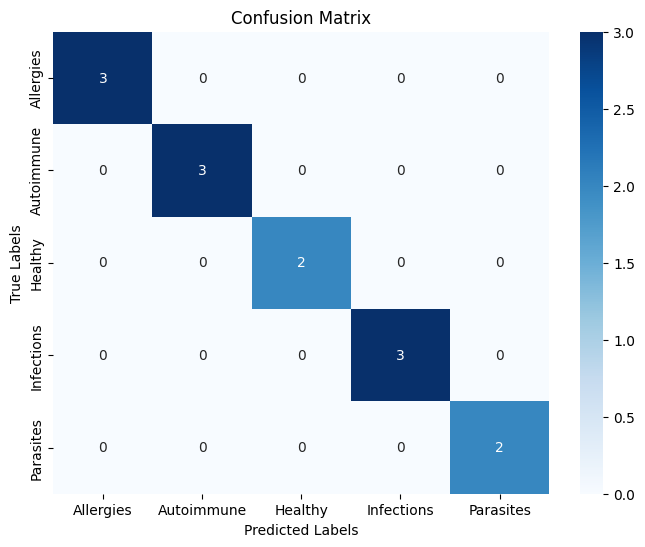

Classification Report:
              precision    recall  f1-score   support

   Allergies       1.00      1.00      1.00         3
  Autoimmune       1.00      1.00      1.00         3
     Healthy       1.00      1.00      1.00         2
  Infections       1.00      1.00      1.00         3
   Parasites       1.00      1.00      1.00         2

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una matriz para almacenar el mejor modelo y su fold
best_model = None
best_accuracy = 0
best_fold = None

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Entrenar el modelo
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluar el modelo en el fold actual
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    
    # Guardar el mejor modelo
    if eval_result[1] > best_accuracy:
        best_accuracy = eval_result[1]
        best_fold = fold
        best_model = model  # Guardar el mejor modelo
    
    fold += 1

print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print(f"Best Fold: {best_fold} with Accuracy: {best_accuracy}")

# Matriz de confusión con el mejor modelo
print("Generating Confusion Matrix for the Best Model...")
y_pred = best_model.predict(x_test)  # Predicciones en el conjunto de prueba
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a etiquetas
y_true = np.argmax(y_test, axis=1)  # Convertir etiquetas categóricas a índices

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))


Loading and preprocessing data...
Found 67 images belonging to 5 classes.
Splitting data into train and test sets...
Training set size: 53
Test set size: 14
Creating model...


/var/folders/ys/ndlktzd129z_51vvh7tqhc8m0000gn/T/ipykernel_43716/515682443.py:52: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Training model...
Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.2335 - loss: 2.4353 - val_accuracy: 0.2857 - val_loss: 1.6032
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3583 - loss: 1.6518 - val_accuracy: 0.3571 - val_loss: 1.5015
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5031 - loss: 1.5441 - val_accuracy: 0.2857 - val_loss: 1.5249
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5021 - loss: 1.2642 - val_accuracy: 0.0714 - val_loss: 1.5681
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6121 - loss: 1.0053 - val_accuracy: 0.2857 - val_loss: 1.5446
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5415 - loss: 1.0275 - val_accuracy: 0.2857 - val_loss: 1.5313
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7548 - loss: 0.6613 - val_accuracy: 0.2857 - val_loss: 1.4886
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6683 - loss: 0.7765 - val_accuracy: 0.3571

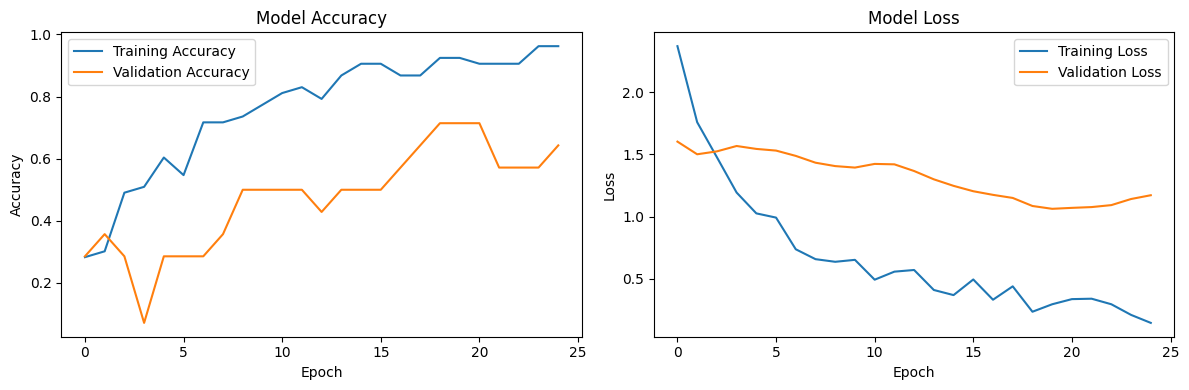


Evaluating model on test set...
Test accuracy: 0.7143
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


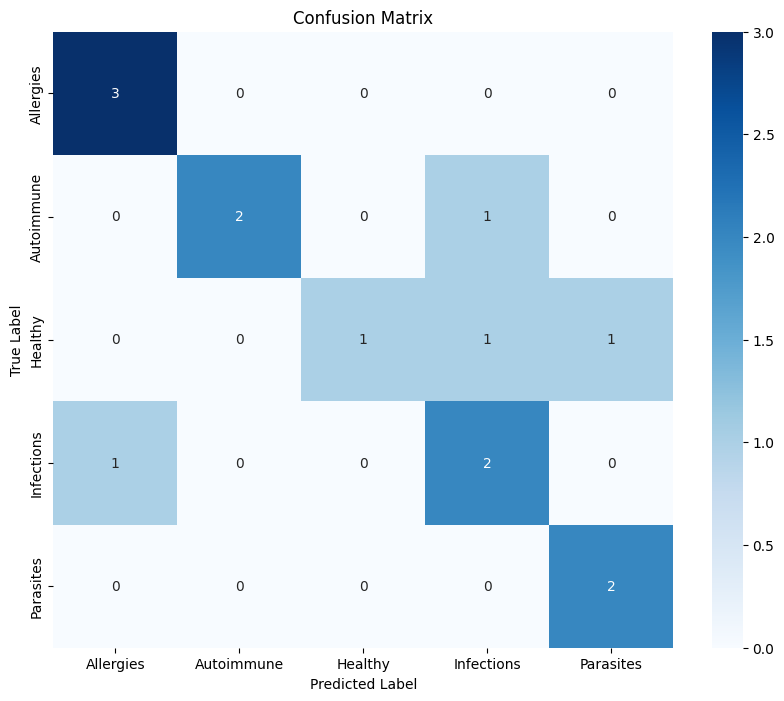


Classification Report:
              precision    recall  f1-score   support

   Allergies       0.75      1.00      0.86         3
  Autoimmune       1.00      0.67      0.80         3
     Healthy       1.00      0.33      0.50         3
  Infections       0.50      0.67      0.57         3
   Parasites       0.67      1.00      0.80         2

    accuracy                           0.71        14
   macro avg       0.78      0.73      0.71        14
weighted avg       0.79      0.71      0.70        14



In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 8
EPOCHS = 40
TEST_SIZE = 0.2  # 20% for testing

def load_and_preprocess_data(data_dir="Dogs2"):
    """
    Load and preprocess images from directory
    """
    # Data Generator for loading images
    datagen = ImageDataGenerator(rescale=1.0/255)
    
    # Load all data
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Get class names
    class_names = list(data_generator.class_indices.keys())
    
    # Collect images and labels
    images, labels = [], []
    for i in range(len(data_generator)):
        img_batch, label_batch = next(data_generator)
        images.extend(img_batch)
        labels.extend(label_batch)
    
    return np.array(images), np.array(labels), class_names

def create_model(num_classes):
    """
    Create a model using MobileNetV2 as base
    """
    # Load the pretrained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    # Freeze the pretrained layers
    base_model.trainable = False
    
    # Create model
    # model = models.Sequential([
    #     base_model,
    #     layers.GlobalAveragePooling2D(),
    #     layers.Dense(128, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.5),
    #     layers.Dense(64, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.3),
    #     layers.Dense(num_classes, activation='softmax')
    # ])
    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



# Load data
print("Loading and preprocessing data...")
images, labels, class_names = load_and_preprocess_data()

# Split data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, 
    test_size=TEST_SIZE, 
    random_state=0,
    stratify=np.argmax(labels, axis=1)  # Stratified split based on classes
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Create and compile model
print("Creating model...")
model = create_model(num_classes=len(class_names))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# Plot training history
plot_training_history(history)

# Evaluate model
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
